## Kaiman filter
forecast

$
x^{a} = x^{b} + K(y^{o}-Hx^{b})
$

$
P_{b} = MP_{a}M^{T}
$

analysis

$
K = P_{b}H^{T}(R+HP_{b}H^{T})^{-1}
$

$
P_{a} = (I-KH)P_{b}
$

In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv


In [8]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,Pa,a):
    h = 0.05#0.01 
    F = 8.0
    #a = 1.1
    
    X1 = Xa
    M = np.eye(N)
    #for i in range(5):
    Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
        #X1 = Xf
    
    M = get_linear(Xa,h,F,N)
    Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = Pf * a
    
    #ERRt = Xf - Xt
    #ERRt_ = 0
    #for i in range(N):
    #    ERRt_ += ERRt[i]/N
    #ERRt = ERRt.reshape(40,1)
    #Pft = (ERRt - ERRt_) @ (ERRt - ERRt_).T
    
    return Xf,Pf#,Pft

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    R = np.eye(N)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Pa

def get_linear(Xa,h,F,N):
    d = 0.00001
    E = np.eye(N)
    MT = []
    MT = [(Rungekutta4(Xa+d*E[j],h,F)-Rungekutta4(Xa,h,F))/d for j in range(N)]
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M

[-2.86150651  2.62584997 -0.15229901  5.77574127  8.94469121  0.82384772
  4.81160964  8.78106832 -0.64896953 -1.18635783  3.6624877  10.96500018
 -0.57050704 -2.49848733 -2.74422318 -0.16702621 -3.70410098  5.08710564
  6.15538941 -0.83699334  3.64207313  8.83840879  7.96966466  4.44227216
  5.12807465  4.65908612 -2.17105472 -2.0673257   0.75896539  9.69644299
  5.44239452  0.31710406  1.28479531 -1.76498904  1.16905622  9.03604993
  1.57485433  2.01164422  5.06932824  2.30618567]
[[25.  0.  0. ...  0.  0.  0.]
 [ 0. 25.  0. ...  0.  0.  0.]
 [ 0.  0. 25. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 25.  0.  0.]
 [ 0.  0.  0. ...  0. 25.  0.]
 [ 0.  0.  0. ...  0.  0. 25.]]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
end


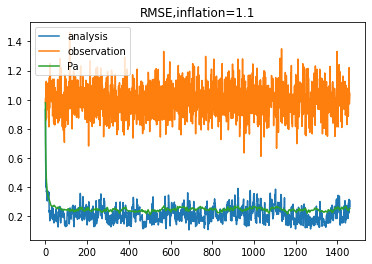

0.2132274332034049


In [10]:
t = 1460
N = 40
h = 0.05 
F = 8.0
#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
Pa = np.eye(N) * 25
print(Xa)
print(Pa)
    
dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
Pt2 = []
P2 = []
C1 = []
C2 = []
errcov = []
a = 1.1
for k in range(t):
    (Xf,Pf) = Forecast(Xa,Pa,a)
    (Xa,Pa) = Analysis(Xf,Pf,y[k,:])
    X1 = Xt[k]
    Y1 = y[k]
    rmse  = np.sqrt(np.sum((Xa-X1)*(Xa-X1))/N)
    rmseo = np.sqrt(np.sum((Y1-X1)*(Y1-X1))/N)
    C1.append(rmse)
    C2.append(rmseo)
    err = np.sqrt(np.sum(np.diag(Pa))/N)
    errcov.append(err)
    if(k%100==0):
        print(k)
#print(X)
#print(P)
print('end')

plt.plot(C1,label="analysis")
plt.plot(C2,label="observation")
plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE,inflation=1.1")
#plt.savefig("KFrmse.png")
plt.show()
print(np.mean(np.array(C1)[500:]))

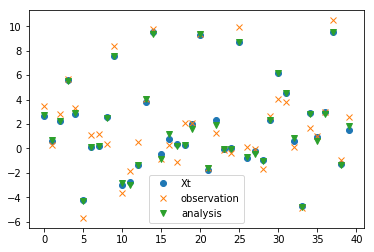

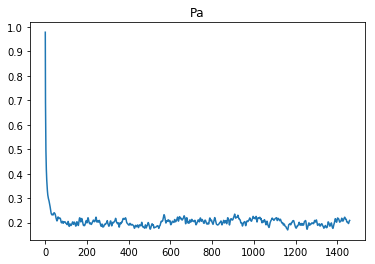

In [8]:
N=40
dataset = pd.read_csv("data.csv")
#print(dataset)
Xt = dataset.values
#print(Xt)

dataset2 = pd.read_csv("observation_data.csv")
#print(dataset2)
Y = dataset2.values
#print(Y)

Xa = np.array(X)
#print(Xa)

site = np.arange(N)
plt.plot(site,Xt[500],label="Xt",marker="o",linewidth=0)
plt.plot(site,Y[500],label="observation",marker="x",linewidth=0)
plt.plot(site,Xa[500],label="analysis",marker="v",linewidth=0)
plt.legend()
plt.show()

plt.plot(errcov)
plt.title("Pa")
plt.show()

### multiple inflation parameter の調整
$P_{a} => P_{a}*\alpha$

In [12]:
def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,Pa,a,N):
    h = 0.01 
    F = 8.0
    
    X1 = Xa
    #M = np.eye(N)
    for i in range(5):
        Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
        X1 = Xf
    
    M = get_linear(Xa,h,F,N)
    Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = Pf * a
    
    return Xf,Pf

def Analysis(Xf,Pf,y,N):
    H = np.eye(N)
    R = np.eye(N)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Pa

def get_linear(Xa,h,F,N):
    d = 0.00001
    E = np.eye(N)
    MT = []
    for j in range(N):
        ej = E[j]
        X2 = Xa + d*ej
        X3 = Xa
        for i in range(5):
            M1 = Rungekutta4(X2,h,F)
            M2 = Rungekutta4(X3,h,F)
            X2 = M1
            X3 = M2
        M3 = (M1-M2)/d
        MT.append(M3)
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M

def inflation(a):
    t = 1460
    N = 40
    h = 0.01 
    F = 8.0
    #初期値
    Xa = np.zeros(N)
    for i in range(N):
        Xa[i] = random.random()
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    for i in range(N):
        Xa[i] += random.random()
    Pa = np.eye(N) * 25
    #print(Xa)
    #print(Pa)
    
    dataset = pd.read_csv("observation_data.csv")
    y = dataset.values
    y = y.reshape(1460,N)
    X = []
    P = []
    errcov = []
    for k in range(t):
        (Xf,Pf) = Forecast(Xa,Pa,a,N)
        (Xa,Pa) = Analysis(Xf,Pf,y[k,:],N)
        X.append(Xa)
        P.append(Pa)
        err = 0
        for j in range(N):
            err += Pa[j,j]
        err = np.sqrt(err/N)
        errcov.append(err)
            
    return X,errcov

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


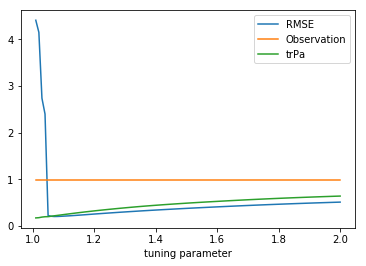

[4.4090099085516075, 4.149475239420487, 2.739395403816454, 2.40033344464225, 0.22557379224509452, 0.21112113704262037, 0.20540118060332752, 0.20667795510759923, 0.20942275792012768, 0.21305075182302158, 0.21679010188406733, 0.2207818886384664, 0.22503439108858017, 0.22958181816892992, 0.2341536370323222, 0.23879964887729738, 0.24358863107070705, 0.24851652403905777, 0.2533988233997966, 0.25830343500289815, 0.26312513185611397, 0.2678192534184875, 0.2724622662534584, 0.27706588075104843, 0.2815889690514383, 0.28606546944425765, 0.29055878527483076, 0.2949832194894636, 0.29932891231175157, 0.3035836642351747, 0.3078023351251005, 0.31199686812984156, 0.3160767978342321, 0.32029815108422194, 0.32439493953365717, 0.3284000616920108, 0.3323304096335132, 0.33620190940390743, 0.34001922821988695, 0.3437753704430434, 0.3474847572202863, 0.35121375564236257, 0.35487882286218103, 0.35848842600730796, 0.36206124257142286, 0.36561047078777537, 0.36919818347505556, 0.37273267102249025, 0.37622710319

In [3]:
N=40
dataset = pd.read_csv("observation_data.csv")
y = dataset.values.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values
delta = []
R = []
RO = []
T = []
for i in range(1,101):
    print(i)
    a = 1 + 0.01*i
    (X,errcov) = inflation(a)
    X_ = np.array(X)
    C1 = []
    N=40
    rmse = 0
    rmse2 = 0
    trPa = 0
    num = 0
    for i in range(500,1460):
        num += 1
        X1 = X_[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i,:]
        Y2 = sum((X2-Y1)*(X2-Y1))/N
        rmse += np.sqrt(X3)
        rmse2 += np.sqrt(Y2)
        trPa += errcov[i]
    rmse = rmse/num
    rmse2 = rmse2/num
    trPa = trPa/num
    
    delta.append(a)
    R.append(rmse)
    RO.append(rmse2)
    T.append(trPa)

plt.plot(delta,R,label="RMSE")
plt.plot(delta,RO,label="Observation")
plt.plot(delta,T,label="trPa")
plt.xlabel("tuning parameter")
plt.legend()
plt.savefig("tuningKF.jpg")
plt.show()
print(R)

### tangent linear model の取得（時間刻み幅を変える）

[ 2.49508488  8.4962075   3.30582909 -2.61221359 -0.59708411 -1.84367684
 -1.85675263  3.12495377  9.80145095  2.93490042  3.81308678  2.76113702
 -1.93162135  4.14001442  4.56052073  2.81634903  4.42565532  0.87670356
 -2.90245909  1.38839767  1.45248883  4.45716927  3.16951397 -5.40786669
  3.77667363  1.44209802 -0.0365071   3.71434221  9.97053056 -0.43113009
 -4.0314208  -3.85560665  0.06350031 -0.59774171  3.62963449 10.4907588
  0.33899961  3.88587332  2.10862542 -0.41614222]
[[25.  0.  0. ...  0.  0.  0.]
 [ 0. 25.  0. ...  0.  0.  0.]
 [ 0.  0. 25. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 25.  0.  0.]
 [ 0.  0.  0. ...  0. 25.  0.]
 [ 0.  0.  0. ...  0.  0. 25.]]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


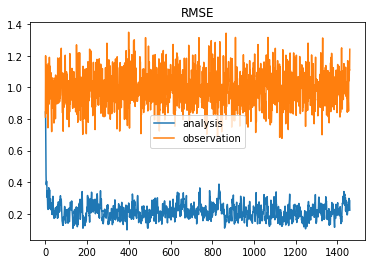

In [6]:

def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,Pa,Xt):
    h = 0.01 
    F = 8.0
    a = 1.1
    
    X1 = Xa
    for i in range(5):
        Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M2 = M_ @ M2
        X1 = Xf
    
    M1 = get_linear(Xa,h,F)
    Pf1 = M1 @ Pa @ M1.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    #Pf2 = M2 @ Pa @ M2.T
    
    #ERRt = Xf - Xt
    #ERRt_ = 0
    #for i in range(N):
    #    ERRt_ += ERRt[i]/N
    #ERRt = ERRt.reshape(40,1)
    #Pft = (ERRt - ERRt_) @ (ERRt - ERRt_).T
    Pf = Pf1 * a
    
    return Xf,Pf

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    R = np.eye(N)
    I = np.eye(N)
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    
    Xa = Xf + K @ (y - H @ Xf)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Pa

def get_linear(Xa,h,F):
    d = 0.00001
    E = np.eye(N)
    MT = []
    for j in range(N):
        ej = E[j]
        X2 = Xa + d*ej
        X3 = Xa
        for i in range(5):
            M1 = Rungekutta4(X2,h,F)
            M2 = Rungekutta4(X3,h,F)
            X2 = M1
            X3 = M2
        M3 = (M1-M2)/d
        MT.append(M3)
        
    M = np.array(MT).reshape(N,N)
    M = M.T
    return M

t = 1460
N = 40
h = 0.01 
F = 8.0
#初期値
Xa = np.zeros(N)
for i in range(N):
    Xa[i] = random.random()
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
Pa = np.eye(N) * 25
print(Xa)
print(Pa)

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
X = []
P = []
errcov = []
for k in range(t):
    (Xf,Pf) = Forecast(Xa,Pa,Xt[k,:])
    (Xa,Pa) = Analysis(Xf,Pf,y[k,:])
    X.append(Xa)
    #P.append(Pa)
    errt = 0
    for j in range(N):
        errt += Pf[j,j]
        
    errt = np.sqrt(errt/N)
    errcov.append(errt)
    if(k%100==0):
        print(k)
#print(X)
#print(P)

Xa = np.array(X)
#print(Xa)

C1 = []
C2 = []
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i,:]
    X3 = sum((X2-X1)*(X2-X1))/N
    Y1 = y[i,:]
    Y2 = sum((X2-Y1)*(X2-Y1))/N
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    C1.append(rmse1)
    C2.append(rmse2)
plt.plot(C1,label="analysis")
plt.plot(C2,label="observation")
plt.legend()
plt.title("RMSE")
#plt.savefig("KFrmse2.jpg")
plt.show()

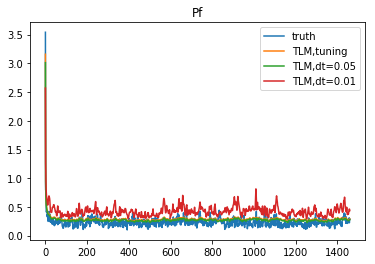

In [30]:
err1 = np.array(P1)-np.array(Pt)
err2 = np.array(P2)-np.array(Pt2)
error1 = np.sqrt(err1**2)
error2 = np.sqrt(err2**2)
#plt.plot(Pt,label="truth,dt=0.05")
#plt.plot(Pt2,label="truth,dt=0.01")
plt.plot(error1,label="TLM,dt=0.05")
plt.plot(error2,label="TLM,dt=0.01")
plt.legend()
plt.title("Pferror")
plt.savefig("Pferror.jpg")
plt.show()

In [27]:
ERRt = Xf - Xt[1400,:]
ERRt_ = 0
for i in range(N):
    ERRt_ += ERRt[i]
ERRt_ = ERRt_/N
ERRt = ERRt.reshape(40,1)
Pft = (ERRt - ERRt_) @ (ERRt - ERRt_).T
print(Pft)

[[60.78940707 -8.35661768  2.42777869 ... -4.79302843 30.49458319
  38.58318501]
 [-8.35661768  1.14877019 -0.33374266 ...  0.65888957 -4.19203913
  -5.30396563]
 [ 2.42777869 -0.33374266  0.09695948 ... -0.19142171  1.21787829
   1.54091706]
 ...
 [-4.79302843  0.65888957 -0.19142171 ...  0.37791324 -2.40438937
  -3.04214684]
 [30.49458319 -4.19203913  1.21787829 ... -2.40438937 15.29739553
  19.35498636]
 [38.58318501 -5.30396563  1.54091706 ... -3.04214684 19.35498636
  24.48884168]]
